INFO:  Logger initialized



INITIALIZING MODEL
[IC] Computed F1 = 1/rd² = 6.25e-10
[IC] Laplacian: [-9.99e-08, 1.00e-07]
[IC] Stretching: [-4.68e-07, 4.68e-07]
[IC] q1: [-5.68e-07, 5.69e-07]
[IC] q2: [-5.19e-07, 5.18e-07]

[pyqg] accepted kwargs: ['H1', 'U1', 'U2', 'beta', 'delta', 'rd']
[pyqg] no hyperviscosity kw accepted; using default

[IC CHECK] After initialization:
  q[0] range: [-5.68e-07, 5.69e-07]
  q[1] range: [-5.19e-07, 5.18e-07]
  [WARNING] psi not available yet - will be computed from q

[GRID INFO]
  Grid: 512×512
  Domain: 2000 km × 2000 km
  Grid spacing: 3.9 km
  Timestep: 1800 s (0.50 hr)
  Rossby radius: 40.0 km
  Dissipation: rek=0.00e+00, nu4=0.00e+00



Integrating QG: 100%|██████████| 17520/17520 [00:21<00:00, 829.85step/s]
getfattr: Removing leading '/' from absolute path names



[OK] Collected 1460 snapshots over 1460.0 days


/explore/nobackup/people/afahad/.nccstmp/ipykernel_841210/80114486.py:402: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"[OK] Wrote {cfg.out_nc} with {ds.dims['time']} snapshots")


[OK] Wrote qg_coarse_128.nc with 1460 snapshots
[DIAG] psi range: [-1.25e+02, 1.47e+02]
[DIAG] zeta range: [-2.24e-07, 1.93e-07]


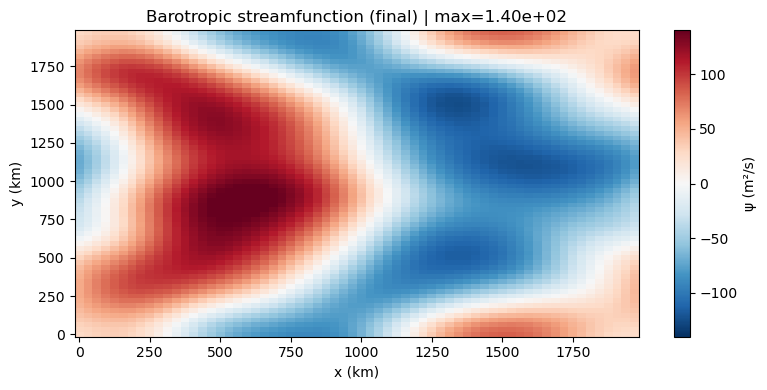

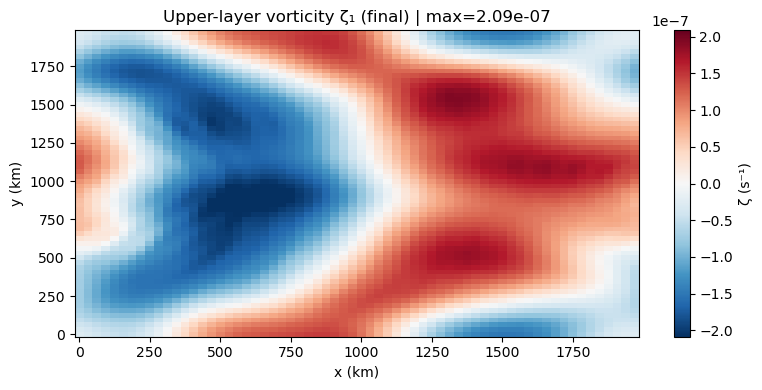

/explore/nobackup/people/afahad/.nccstmp/ipykernel_841210/80114486.py:461: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for i in range(ds.dims['time'])])
/explore/nobackup/people/afahad/.nccstmp/ipykernel_841210/80114486.py:462: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  time_days = np.arange(ds.dims['time']) * cfg.snap_every_steps * cfg.dt / 86400.0


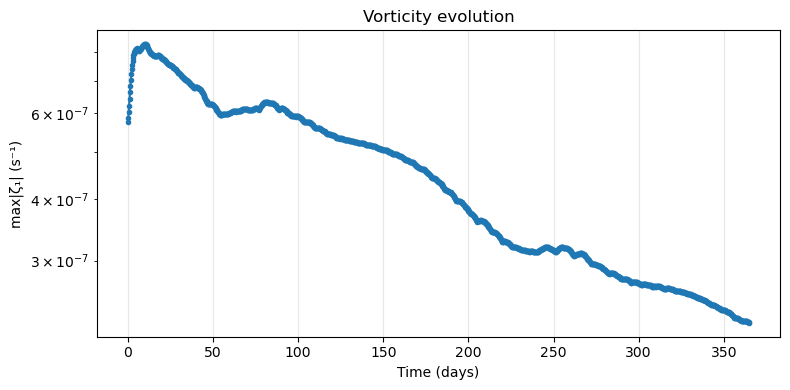

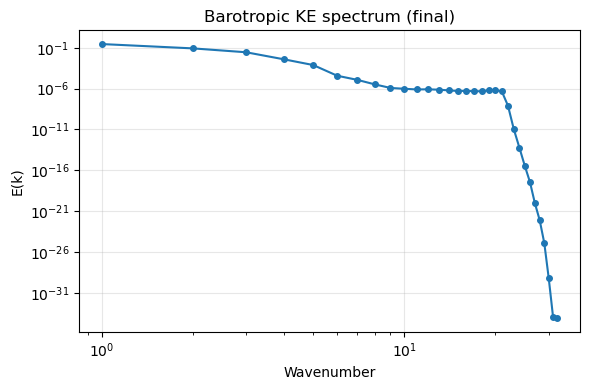

[ANIM] Vorticity range for colormap: ±4.78e-07
[ANIM] Creating 365 frames
[OK] Saved qg_vorticity.mp4


In [24]:
# --- Single-cell two-layer QG (pyqg) — version-adaptive kwargs + tqdm ---
import inspect, os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from dataclasses import dataclass, asdict
from tqdm import trange
import pyqg

# ============ CONFIG ============
@dataclass
class Config:
    nx: int = 512             
    L: float = 2.0e6
    beta: float = 1.6e-11
    H1: float = 500.0
    H2: float = 4500.0
    rd: float = 4.0e4
    U1: float = 0.0           
    U2: float = 0.0
    rek: float = 0.0          
    nu4_like: float = 0.0     
    dt: float = 1800.0        
    days: float = 365.0        
    snap_every_steps: int = 12
    forcing_amp: float = 0.0  
    forcing_kmin_mult: float = 6.0
    forcing_kmax_mult: float = 14.0
    forcing_spinup_days: float = 5.0
    seed: int = 1234
    out_nc: str = "qg_coarse_128.nc"
    make_plots: bool = True
    animate: bool = True
    anim_fps: int = 30
    anim_skip: int = 4        # skip frames for faster animation

cfg = Config()

# ============ Helpers ============
def _qg_kwargs(cfg: Config):
    """Build kwargs for pyqg.QGModel, filtering by supported parameters."""
    sig = inspect.signature(pyqg.QGModel.__init__)
    allowed = set(sig.parameters.keys())
    delta = cfg.H1 / cfg.H2

    base = dict(
        nx=cfg.nx, ny=cfg.nx, L=cfg.L, W=cfg.L,
        beta=cfg.beta, rd=cfg.rd, delta=delta,
        H1=cfg.H1, U1=cfg.U1, U2=cfg.U2,
        rek=cfg.rek, dt=cfg.dt,
    )

    # Try hyperviscosity under common names
    hv_names = ["mu4", "mu", "visc", "nu"]
    hv_used = None
    for name in hv_names:
        if name in allowed:
            base[name] = cfg.nu4_like
            hv_used = name
            break

    filtered = {k: v for k, v in base.items() if k in allowed}
    return filtered, hv_used, allowed

def build_model(cfg: Config, seed=None):
    rng = np.random.default_rng(cfg.seed if seed is None else seed)
    kwargs, hv_used, allowed = _qg_kwargs(cfg)
    m = pyqg.QGModel(**kwargs)

    # Even stronger IC for clear visualization
    print("\n" + "="*60)
    print("INITIALIZING MODEL")
    print("="*60)
    add_vortex_ic(m, amp=500.0, sigma_frac=0.10)  # 500 m²/s amplitude
    
    # Very small random perturbation
    for j in (0, 1):
        m.q[j] += 1e-10 * rng.standard_normal(m.q[j].shape)

    print("\n[pyqg] accepted kwargs:", sorted(kwargs.keys()))
    if hv_used:
        print(f"[pyqg] hyperviscosity passed as '{hv_used}' = {cfg.nu4_like:g}")
    else:
        print("[pyqg] no hyperviscosity kw accepted; using default")
    
    # Check what pyqg actually has after initialization
    print(f"\n[IC CHECK] After initialization:")
    print(f"  q[0] range: [{m.q[0].min():.2e}, {m.q[0].max():.2e}]")
    print(f"  q[1] range: [{m.q[1].min():.2e}, {m.q[1].max():.2e}]")
    
    # Compute actual fields from pyqg's state
    if hasattr(m, 'psi') and m.psi is not None:
        print(f"  psi[0] range: [{m.psi[0].min():.2e}, {m.psi[0].max():.2e}]")
        print(f"  psi[1] range: [{m.psi[1].min():.2e}, {m.psi[1].max():.2e}]")
        
        # Barotropic and baroclinic modes
        psi_bt = 0.5 * (m.psi[0] + m.psi[1])
        psi_bc = m.psi[0] - m.psi[1]
        
        dx = m.L / m.nx
        dy = m.L / m.ny
        u_bt = -np.gradient(psi_bt, dy, axis=0)
        v_bt = np.gradient(psi_bt, dx, axis=1)
        max_vel = np.sqrt(u_bt**2 + v_bt**2).max()
        
        zeta1 = _lap_from_L(m.psi[0], m.L)
        zeta_bt = _lap_from_L(psi_bt, m.L)
        zeta_bc = _lap_from_L(psi_bc, m.L)
        
        print(f"  max barotropic velocity: {max_vel:.4f} m/s")
        print(f"  max layer-1 vorticity: {np.abs(zeta1).max():.2e} s⁻¹")
        print(f"  max barotropic vorticity: {np.abs(zeta_bt).max():.2e} s⁻¹")
        print(f"  max baroclinic vorticity: {np.abs(zeta_bc).max():.2e} s⁻¹")
    else:
        print("  [WARNING] psi not available yet - will be computed from q")
    
    print(f"\n[GRID INFO]")
    print(f"  Grid: {cfg.nx}×{cfg.nx}")
    print(f"  Domain: {cfg.L/1e3:.0f} km × {cfg.L/1e3:.0f} km")
    print(f"  Grid spacing: {cfg.L/cfg.nx/1e3:.1f} km")
    print(f"  Timestep: {cfg.dt:.0f} s ({cfg.dt/3600:.2f} hr)")
    print(f"  Rossby radius: {cfg.rd/1e3:.1f} km")
    print(f"  Dissipation: rek={cfg.rek:.2e}, nu4={cfg.nu4_like:.2e}")
    print("="*60 + "\n")

    return m, rng

def ring_forcing(m, rng, cfg: Config, current_time=0.0):
    """Band-limited forcing in spectral space with gradual spin-up."""
    ny, nx = m.ny, m.nx
    kmin = cfg.forcing_kmin_mult * (2*np.pi / m.L)
    kmax = cfg.forcing_kmax_mult * (2*np.pi / m.L)

    # Construct mask on rfft2 grid
    mask = (m.wv >= kmin) & (m.wv <= kmax)

    # Generate noise in real space, transform to spectral
    noise = rng.standard_normal((ny, nx))
    nhat = np.fft.rfft2(noise)

    # Apply band-pass filter
    fhat = np.zeros_like(nhat, dtype=complex)
    fhat[mask] = nhat[mask]

    # Transform back to physical space
    f = np.fft.irfft2(fhat, s=(ny, nx))
    
    # Gradual spin-up: ramp forcing from 0 to full over spinup_days
    spinup_time = cfg.forcing_spinup_days * 86400.0
    if current_time < spinup_time:
        ramp = np.sin(0.5 * np.pi * current_time / spinup_time)
    else:
        ramp = 1.0
    
    f *= cfg.forcing_amp * ramp

    # Anti-symmetric forcing for baroclinic injection
    return f, -f

def isotropic_ke_spectrum(u_bt, v_bt):
    """Compute isotropic KE spectrum."""
    uh = np.fft.fft2(u_bt)
    vh = np.fft.fft2(v_bt)
    E2D = 0.5 * (np.abs(uh)**2 + np.abs(vh)**2)
    
    ny, nx = u_bt.shape
    ky = np.fft.fftfreq(ny, d=1.0) * ny
    kx = np.fft.fftfreq(nx, d=1.0) * nx
    KX, KY = np.meshgrid(kx, ky, indexing='ij')
    kr = np.sqrt(KX**2 + KY**2)
    
    bins = np.arange(1, min(nx, ny)//2 + 1)
    Ek = np.array([E2D[(kr >= b-0.5) & (kr < b+0.5)].mean() for b in bins])
    
    # Handle NaN values
    Ek = np.nan_to_num(Ek, nan=0.0)
    return bins, Ek

def get_barotropic_uv_and_psi(m):
    """Extract barotropic velocity and streamfunction."""
    ny, nx = m.ny, m.nx
    dx = m.L / nx
    dy = m.L / ny
    psi_bt = None

    # Try direct velocities first
    if hasattr(m, "u") and hasattr(m, "v"):
        u = m.u
        v = m.v
        u_bt = 0.5 * (u[0] + u[1])
        v_bt = 0.5 * (v[0] + v[1])
        if hasattr(m, "psi"):
            psi_bt = 0.5 * (m.psi[0] + m.psi[1])
        return u_bt, v_bt, psi_bt

    # Compute from streamfunction
    if hasattr(m, "psi"):
        psi_bt = 0.5 * (m.psi[0] + m.psi[1])
        u_bt = -np.gradient(psi_bt, dy, axis=0)
        v_bt = np.gradient(psi_bt, dx, axis=1)
        return u_bt, v_bt, psi_bt

    return None, None, None

def poisson_from_vorticity(zeta, L):
    """Solve ∇²ψ = ζ on periodic domain."""
    ny, nx = zeta.shape
    kx = np.fft.fftfreq(nx, d=(L/nx)) * 2*np.pi
    ky = np.fft.fftfreq(ny, d=(L/ny)) * 2*np.pi
    KX, KY = np.meshgrid(kx, ky, indexing='ij')
    kk2 = KX**2 + KY**2
    
    zh = np.fft.fft2(zeta)
    psi_h = np.zeros_like(zh, dtype=complex)
    mask = kk2 != 0
    psi_h[mask] = zh[mask] / (-kk2[mask])
    return np.fft.ifft2(psi_h).real

def _lap_from_L(f, L):
    """Compute Laplacian using FFT."""
    ny, nx = f.shape
    kx = 2*np.pi * np.fft.fftfreq(nx, d=L/nx)
    ky = 2*np.pi * np.fft.fftfreq(ny, d=L/ny)
    KX, KY = np.meshgrid(kx, ky, indexing='ij')
    kk2 = KX**2 + KY**2
    
    fh = np.fft.fft2(f)
    zh = -kk2 * fh
    return np.fft.ifft2(zh).real

def add_vortex_ic(m, amp=500.0, sigma_frac=0.10):
    """Add vortex pair initial condition using streamfunction amplitude.
    
    amp: streamfunction amplitude in m²/s (500 gives strong visible dynamics)
    """
    ny, nx = m.ny, m.nx
    y = np.linspace(0, m.L, ny, endpoint=False)
    x = np.linspace(0, m.L, nx, endpoint=False)
    X, Y = np.meshgrid(x, y, indexing='xy')
    sigma = sigma_frac * m.L

    def gaussian(x0, y0):
        r2 = (X - x0)**2 + (Y - y0)**2
        return np.exp(-r2 / (2*sigma**2))

    # Create streamfunction dipole (units: m²/s)
    psi1 = amp * (gaussian(0.30*m.L, 0.50*m.L) - gaussian(0.70*m.L, 0.50*m.L))
    psi2 = -0.5 * psi1

    # Try setting streamfunction directly if possible
    if hasattr(m, "set_psi1psi2"):
        print("[IC] Using set_psi1psi2 method")
        m.set_psi1psi2(psi1, psi2)
        return
    
    # Compute PV: F = 1/rd²
    if hasattr(m, 'F'):
        F_pyqg = m.F
        if hasattr(F_pyqg, '__len__'):
            F1 = F_pyqg[0]
        else:
            F1 = F_pyqg
        print(f"[IC] Found pyqg's F: {F1:.2e}")
    elif hasattr(m, 'kdi'):
        F1 = m.kdi**2
        print(f"[IC] Using kdi²: {F1:.2e}")
    else:
        F1 = 1.0 / (m.rd**2)
        print(f"[IC] Computed F1 = 1/rd² = {F1:.2e}")
    
    lap1 = _lap_from_L(psi1, m.L)
    lap2 = _lap_from_L(psi2, m.L)
    
    # Full QGPV: q = ∇²ψ + F·(ψ_other - ψ)
    q1 = lap1 + F1 * (psi2 - psi1)
    q2 = lap2 + F1 * (psi1 - psi2)
    
    print(f"[IC] Laplacian: [{lap1.min():.2e}, {lap1.max():.2e}]")
    print(f"[IC] Stretching: [{(F1*(psi2-psi1)).min():.2e}, {(F1*(psi2-psi1)).max():.2e}]")
    print(f"[IC] q1: [{q1.min():.2e}, {q1.max():.2e}]")
    print(f"[IC] q2: [{q2.min():.2e}, {q2.max():.2e}]")
    
    if hasattr(m, "set_q1q2"):
        m.set_q1q2(q1, q2)
    else:
        m.q[0] = q1
        m.q[1] = q2

def _nc_safe_attrs(d):
    """Convert attributes to NetCDF-safe types."""
    out = {}
    for k, v in d.items():
        if isinstance(v, bool):
            out[k] = int(v)
        elif isinstance(v, (int, float, str, np.integer, np.floating)):
            out[k] = v
        else:
            out[k] = str(v)
    return out

# ============ Main Run ============
def run(cfg: Config):
    total_steps = int((cfg.days * 86400.0) / cfg.dt)
    m, rng = build_model(cfg)

    times, psi_bt_list, zeta1_list, ubar_list, Ek_list = [], [], [], [], []

    for i in trange(total_steps, desc="Integrating QG", unit="step"):
        # Apply forcing with gradual spin-up
        current_time = (i + 1) * m.dt
        f1, f2 = ring_forcing(m, rng, cfg, current_time)
        m.q[0] += f1 * m.dt
        m.q[1] += f2 * m.dt
        
        # Check for NaN before stepping
        if np.any(np.isnan(m.q[0])) or np.any(np.isnan(m.q[1])):
            print(f"\n[ERROR] NaN detected in q BEFORE step {i+1}")
            print(f"[ERROR] Time: {current_time/86400:.2f} days")
            break
        
        # Step forward
        try:
            m._step_forward()
        except (AssertionError, ValueError) as e:
            print(f"\n[ERROR] Model failed at step {i+1} (t={current_time/86400:.2f} days)")
            print(f"[ERROR] Error: {e}")
            break
        
        # Check for NaN after stepping
        if np.any(np.isnan(m.q[0])) or np.any(np.isnan(m.q[1])):
            print(f"\n[ERROR] NaN detected in q AFTER step {i+1}")
            print(f"[ERROR] Time: {current_time/86400:.2f} days")
            break

        step = i + 1
        if (step % cfg.snap_every_steps == 0) or (step == total_steps):
            u_bt, v_bt, psi_bt = get_barotropic_uv_and_psi(m)

            if u_bt is None or v_bt is None:
                print("[ERROR] Could not obtain velocities from pyqg model")
                break

            # Check for NaN in derived fields
            if np.any(np.isnan(u_bt)) or np.any(np.isnan(v_bt)):
                print(f"\n[ERROR] NaN in velocities at step {step}")
                break

            # Compute psi_bt if not available
            if psi_bt is None:
                dv_dx = np.gradient(v_bt, axis=1) * (m.nx / m.L)
                du_dy = np.gradient(u_bt, axis=0) * (m.ny / m.L)
                zeta_bt = dv_dx - du_dy
                psi_bt = poisson_from_vorticity(zeta_bt, m.L)

            kbins, Ek = isotropic_ke_spectrum(u_bt, v_bt)

            # Get upper-layer vorticity
            if hasattr(m, "psi"):
                zeta1 = _lap_from_L(m.psi[0], m.L)
            else:
                zeta1 = m.q[0]
            
            # # Diagnostic output every few saves
            # if len(times) % 10 == 0:
            #     print(f"\n[DIAG t={current_time/86400:.1f}d] max|ζ₁|={np.abs(zeta1).max():.2e}, "
            #           f"max|ψ|={np.abs(psi_bt).max():.2e}")

            times.append(step * m.dt)
            psi_bt_list.append(psi_bt.astype(np.float32))
            zeta1_list.append(zeta1.astype(np.float32))
            ubar_list.append(u_bt.mean(axis=1).astype(np.float32))
            Ek_list.append(Ek.astype(np.float32))

    if len(times) == 0:
        print("[ERROR] No data collected - model failed immediately")
        return

    print(f"\n[OK] Collected {len(times)} snapshots over {times[-1]/86400:.1f} days")

    # Save to NetCDF
    ny, nx = psi_bt_list[-1].shape
    attrs = _nc_safe_attrs(asdict(cfg))
    attrs["title"] = "pyqg 2-layer QG coarse run (version-adaptive)"
    
    ds = xr.Dataset(
        data_vars=dict(
            psi_bt=(("time", "y", "x"), np.stack(psi_bt_list)),
            zeta1=(("time", "y", "x"), np.stack(zeta1_list)),
            ubar=(("time", "y"), np.stack(ubar_list)),
            Ek=(("time", "k"), np.stack(Ek_list)),
        ),
        coords=dict(
            time=np.arange(len(times)),
            y=np.linspace(0, cfg.L, ny, endpoint=False),
            x=np.linspace(0, cfg.L, nx, endpoint=False),
            k=kbins,
        ),
        attrs=attrs,
    )
    ds.to_netcdf(cfg.out_nc)
    print(f"[OK] Wrote {cfg.out_nc} with {ds.dims['time']} snapshots")

    if cfg.make_plots:
        make_plots(ds, cfg)
    
    if cfg.animate:
        make_animation(ds, cfg)

def make_plots(ds, cfg):
    """Generate diagnostic plots."""
    # Check if we have any meaningful data
    psi_last = ds["psi_bt"].isel(time=-1).values
    zlast = ds["zeta1"].isel(time=-1).values
    
    print(f"[DIAG] psi range: [{psi_last.min():.2e}, {psi_last.max():.2e}]")
    print(f"[DIAG] zeta range: [{zlast.min():.2e}, {zlast.max():.2e}]")
    
    # Streamfunction
    psi_scale = np.max(np.abs(np.percentile(psi_last, [1, 99])))
    if not np.isfinite(psi_scale) or psi_scale == 0:
        psi_scale = np.max(np.abs(psi_last))
    if psi_scale == 0:
        psi_scale = 1.0
    
    plt.figure(figsize=(8, 4))
    im = plt.pcolormesh(ds["x"]/1e3, ds["y"]/1e3, psi_last, 
                        shading="nearest", cmap="RdBu_r",
                        vmin=-psi_scale, vmax=psi_scale)
    plt.xlabel("x (km)")
    plt.ylabel("y (km)")
    plt.title(f"Barotropic streamfunction (final) | max={psi_scale:.2e}")
    cbar = plt.colorbar(im, label="ψ (m²/s)")
    cbar.formatter.set_powerlimits((-3, 3))
    plt.tight_layout()
    plt.savefig("psi_final.png", dpi=150, bbox_inches='tight')
    plt.show()

    # Vorticity with better scaling
    z_scale = np.max(np.abs(np.percentile(zlast, [1, 99])))
    if not np.isfinite(z_scale) or z_scale == 0:
        z_scale = np.max(np.abs(zlast))
    if z_scale == 0:
        z_scale = 1e-10  # fallback
    
    plt.figure(figsize=(8, 4))
    im = plt.pcolormesh(ds["x"]/1e3, ds["y"]/1e3, zlast, shading="nearest",
                        cmap="RdBu_r", vmin=-z_scale, vmax=z_scale)
    plt.xlabel("x (km)")
    plt.ylabel("y (km)")
    plt.title(f"Upper-layer vorticity ζ₁ (final) | max={z_scale:.2e}")
    cbar = plt.colorbar(im, label="ζ (s⁻¹)")
    cbar.formatter.set_powerlimits((-3, 3))
    plt.tight_layout()
    plt.savefig("vorticity_final.png", dpi=150, bbox_inches='tight')
    plt.show()

    # Time evolution of max vorticity
    plt.figure(figsize=(8, 4))
    max_zeta = np.array([np.abs(ds["zeta1"].isel(time=i).values).max() 
                         for i in range(ds.dims['time'])])
    time_days = np.arange(ds.dims['time']) * cfg.snap_every_steps * cfg.dt / 86400.0
    plt.semilogy(time_days, max_zeta, 'o-', markersize=3)
    plt.xlabel("Time (days)")
    plt.ylabel("max|ζ₁| (s⁻¹)")
    plt.title("Vorticity evolution")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("vorticity_evolution.png", dpi=150, bbox_inches='tight')
    plt.show()

    # KE spectrum with better handling
    Ek_last = ds["Ek"].isel(time=-1).values
    valid = Ek_last > 0
    
    plt.figure(figsize=(6, 4))
    if np.any(valid):
        plt.loglog(ds["k"].values[valid], Ek_last[valid], 'o-', markersize=4)
        plt.xlabel("Wavenumber")
        plt.ylabel("E(k)")
        plt.title("Barotropic KE spectrum (final)")
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, "No valid spectral data", 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title("KE spectrum (no data)")
    plt.tight_layout()
    plt.savefig("spectrum_final.png", dpi=150, bbox_inches='tight')
    plt.show()

def make_animation(ds, cfg):
    """Create animation of vorticity evolution."""
    X, Y = np.meshgrid(ds["x"].values/1e3, ds["y"].values/1e3, indexing="xy")
    zarr = ds["zeta1"].values[::cfg.anim_skip]
    tframes = zarr.shape[0]
    
    # Use tighter percentiles and check for actual variation
    clim = np.max(np.abs(np.percentile(zarr, [1, 99])))
    if not np.isfinite(clim) or clim == 0:
        clim = np.max(np.abs(zarr))
    if clim == 0:
        clim = 1e-10  # prevent division by zero
    
    print(f"[ANIM] Vorticity range for colormap: ±{clim:.2e}")
    print(f"[ANIM] Creating {tframes} frames")
    
    fig, ax = plt.subplots(figsize=(8, 4))
    im = ax.pcolormesh(X, Y, zarr[0], shading="nearest", 
                       cmap="RdBu_r", vmin=-clim, vmax=clim)
    cbar = plt.colorbar(im, ax=ax, label="ζ₁ (s⁻¹)")
    cbar.formatter.set_powerlimits((-3, 3))
    ax.set_xlabel("x (km)")
    ax.set_ylabel("y (km)")
    ttl = ax.set_title("ζ₁ (t=0 h)")

    def update(i):
        im.set_array(zarr[i].ravel())
        hours = int((i * cfg.snap_every_steps * cfg.anim_skip * cfg.dt) / 3600)
        days = hours / 24.0
        ttl.set_text(f"ζ₁ (t={days:.1f} days, {hours} h)")
        return im, ttl

    anim = animation.FuncAnimation(fig, update, frames=tframes, 
                                   interval=1000/cfg.anim_fps, blit=False)
    
    # Try saving as MP4
    try:
        Writer = animation.writers['ffmpeg']
        writer = Writer(fps=cfg.anim_fps, metadata=dict(artist='qg'), bitrate=2000)
        anim.save("qg_vorticity.mp4", writer=writer)
        print("[OK] Saved qg_vorticity.mp4")
    except Exception as e:
        print(f"[WARN] MP4 save failed: {e}")
        # Fallback to GIF
        try:
            from matplotlib.animation import PillowWriter
            anim.save("qg_vorticity.gif", writer=PillowWriter(fps=cfg.anim_fps))
            print("[OK] Saved qg_vorticity.gif")
        except Exception as e2:
            print(f"[WARN] GIF save failed: {e2}")
    
    plt.close(fig)

# Run the simulation
if __name__ == "__main__":
    run(cfg)